In [1]:
%matplotlib notebook
import numpy as np
import pylab as plt

from ipywidgets import interact, interactive, fixed, interact_manual
import ipywidgets as widgets

from scipy.optimize import curve_fit

from scipy.ndimage import gaussian_filter1d
from galaxies_widget import get_sn_xhdist

## Closed Box Model

In [2]:
t = np.linspace(0, 13e9, 20)
Zsolar = 0.014

def fgas(t, mode='', tau=11e9):
    """
    Gas fraction
    """
    if mode == 'constant':
        C = 0.7 / 13e9
        fraction = 1 - C * t
        return fraction
    
    else:
        C = 0.7 / (tau - tau * np.exp(-13e9 / tau))
        fraction = 1 - C * (tau - tau * np.exp(-t / tau))
        return fraction 

def calc_metallicity(t, mode='constant', tau=11e9, z_yield=0.5):
    """
    """
    return -z_yield * np.log(fgas(t, mode=mode, tau=tau))

def metallicity_distribution(Z, z_yield=0.01):
    """
    """
    Z *= Zsolar
    return Z / z_yield * np.exp(-Z / z_yield)

def fit_closed(logZ, z_yield=0.01):
    """
    """
    dN = metallicity_distribution(10 ** logZ, z_yield=z_yield)
    return dN / np.trapz(dN, logZ)

## Leaky Box Model

In [3]:
def calc_metallicity_leaky(t, mode='constant', tau=11e9, z_yield=0.01, eta=3):
    """
    """
    return -z_yield / (1 + eta) * np.log(fgas(t, mode=mode, tau=tau))

def metallicity_distribution_leaky(Z, z_yield=0.01, eta=3):
    """
    """
    Z *= Zsolar
    pp = z_yield / (1 + eta)
    return Z / pp * np.exp(-Z / pp)

def fit_leaky(logZ, z_yield=0.01, eta=3):
    """
    """
    dN = metallicity_distribution_leaky(10 ** logZ, z_yield=z_yield, eta=eta)
    return dN / np.trapz(dN, logZ)


## Accreting Box Model

In [4]:
def calc_metallicity_accreting(t, mode='constant', tau=11e9, z_yield=0.01, eta=3):
    """
    """
    return calc_metallicity_accreting_leaky(t, mode=mode, tau=tau, z_yield=z_yield, eta=eta, r=0)

def calc_metallicity_accreting_leaky(t, mode='constant', tau=11e9, z_yield=0.01, eta=3, r=0.4):
    """
    """
    return z_yield / (1 + eta - r) * (1 - np.exp((1 + eta - r) / (1 - r) * (1 - 1 / fgas(t, mode=mode, tau=tau))))

def dNdZ_accreting(Z):
    """
    """

def metallicity_distribution_accreting(Z, z_yield=0.01):
    """
    """
    return Z / z_yield * np.exp(-Z / z_yield)

def metallicity_distribution_accreting_leaky(Z, z_yield=0.01, eta=3, r=0.5):
    """
    """
    Z *= Zsolar
    pp = z_yield / (1 + eta - r)
    m = Z / (pp - Z)
    m[Z > pp] = 0
    return m

def fit_accreting(logZ, z_yield=0.01, eta=3):
    """
    """
    dN = metallicity_distribution_accreting_leaky(10 ** logZ, z_yield=z_yield, eta=eta, r=0)
    k = gaussian_filter1d(np.abs(dN), 3)
    dk = k / np.trapz(k, logZ)
    return dk

def fit_accreting_leaky(logZ, z_yield=0.01, eta=3, r=0.5):
    """
    """
    dN = metallicity_distribution_accreting_leaky(10 ** logZ, z_yield=z_yield, eta=eta, r=r)
    k = gaussian_filter1d(np.abs(dN), 3)
    dk = k / np.trapz(k, logZ)
    return dk


## Fitting

<IPython.core.display.Javascript object>


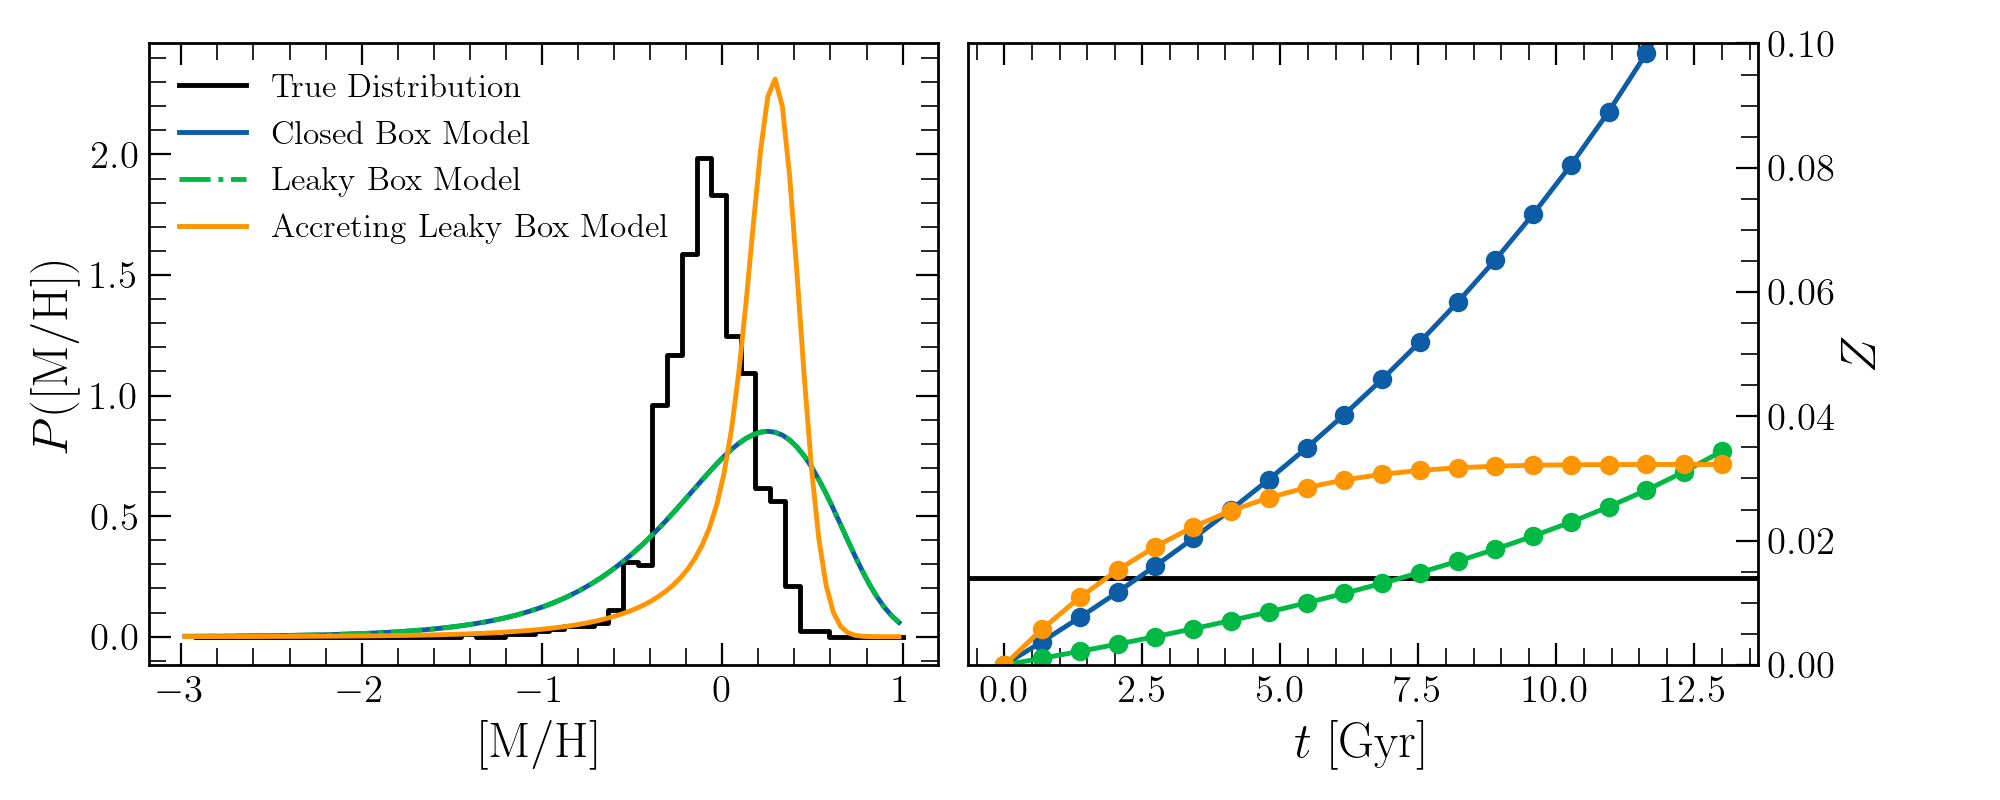

interactive(children=(FloatSlider(value=0.1, description='z_yield', max=0.2, step=0.01), FloatSlider(value=2.5…

<function __main__.update(z_yield=0.1, eta=2.5, r=0.4)>

In [10]:
fig, axs = plt.subplots(1, 2, figsize=(10, 4))
ax1, ax2 = axs[0], axs[1]

ti = t / 1e9

# True Distribution
c, b = get_sn_xhdist("Mg", bins=np.linspace(-3, 1, 50))
line1, = ax1.step(b + np.diff(b)[0] / 2, c / np.trapz(c, b), label='True Distribution', color='k')

# Fit Distribution -> Closed
c, b = get_sn_xhdist("Mg", bins=np.linspace(-3, 1, 100))
dN = metallicity_distribution(10 ** b)
line2, = ax1.plot(b, dN / np.trapz(dN, b), label='Closed Box Model')

# Fit Distribution -> Leaky
dN = metallicity_distribution_leaky(10 ** b)
line3, = ax1.plot(b, dN / np.trapz(dN, b), label='Leaky Box Model', ls='-.')


# Fit Distribution -> Leaky Accreting
dN = metallicity_distribution_accreting_leaky(10 ** b)
k = gaussian_filter1d(np.abs(dN), 3)
line4, = ax1.plot(b, k / np.trapz(k, b), label='Accreting Leaky Box Model')
ax1.legend(frameon=False, fontsize=12)
ax1.set_xlabel(r'$[\rm M/H]$')
ax1.set_ylabel(r'$P([\rm M/H])$')

ax2.axhline(Zsolar, color='k', label=r'$Z_{\odot}$')
line5, = ax2.plot(ti, calc_metallicity(t), marker='o')
line6, = ax2.plot(ti, calc_metallicity_leaky(t), marker='o')
line7, = ax2.plot(ti, calc_metallicity_accreting_leaky(t), marker='o')

ax2.set_ylim([0, 0.1])
ax2.yaxis.tick_right()
ax2.set_xlabel(r'$t$ [Gyr]')
ax2.set_ylabel(r'$Z$', labelpad=-330)
fig.tight_layout()


def update(z_yield=0.1, eta=2.5, r=0.4):
    """
    """ 
    dN = metallicity_distribution_leaky(10 ** b, z_yield=z_yield)
    line2.set_ydata(dN / np.trapz(dN, b))
    
    dN = metallicity_distribution_leaky(10 ** b, z_yield=z_yield)
    line3.set_ydata(dN / np.trapz(dN, b))
    
    dN = metallicity_distribution_accreting_leaky(10 ** b, z_yield=z_yield, eta=eta, r=r)
    k = gaussian_filter1d(np.abs(dN), 3)
    line4.set_ydata(k / np.trapz(k, b))
    
    
    g = calc_metallicity_accreting_leaky(t, z_yield=z_yield, eta=eta, r=r)
    h = calc_metallicity_leaky(t, z_yield=z_yield, eta=eta)
    i = calc_metallicity(t, z_yield=z_yield)
    line5.set_ydata(i)
    line6.set_ydata(h)
    line7.set_ydata(g)
    
    fig.canvas.draw()


interact(update, z_yield=(0.0, 0.2, 0.01), eta=(0, 5, 0.05), r=(0, 0.9, 0.05))

<IPython.core.display.Javascript object>


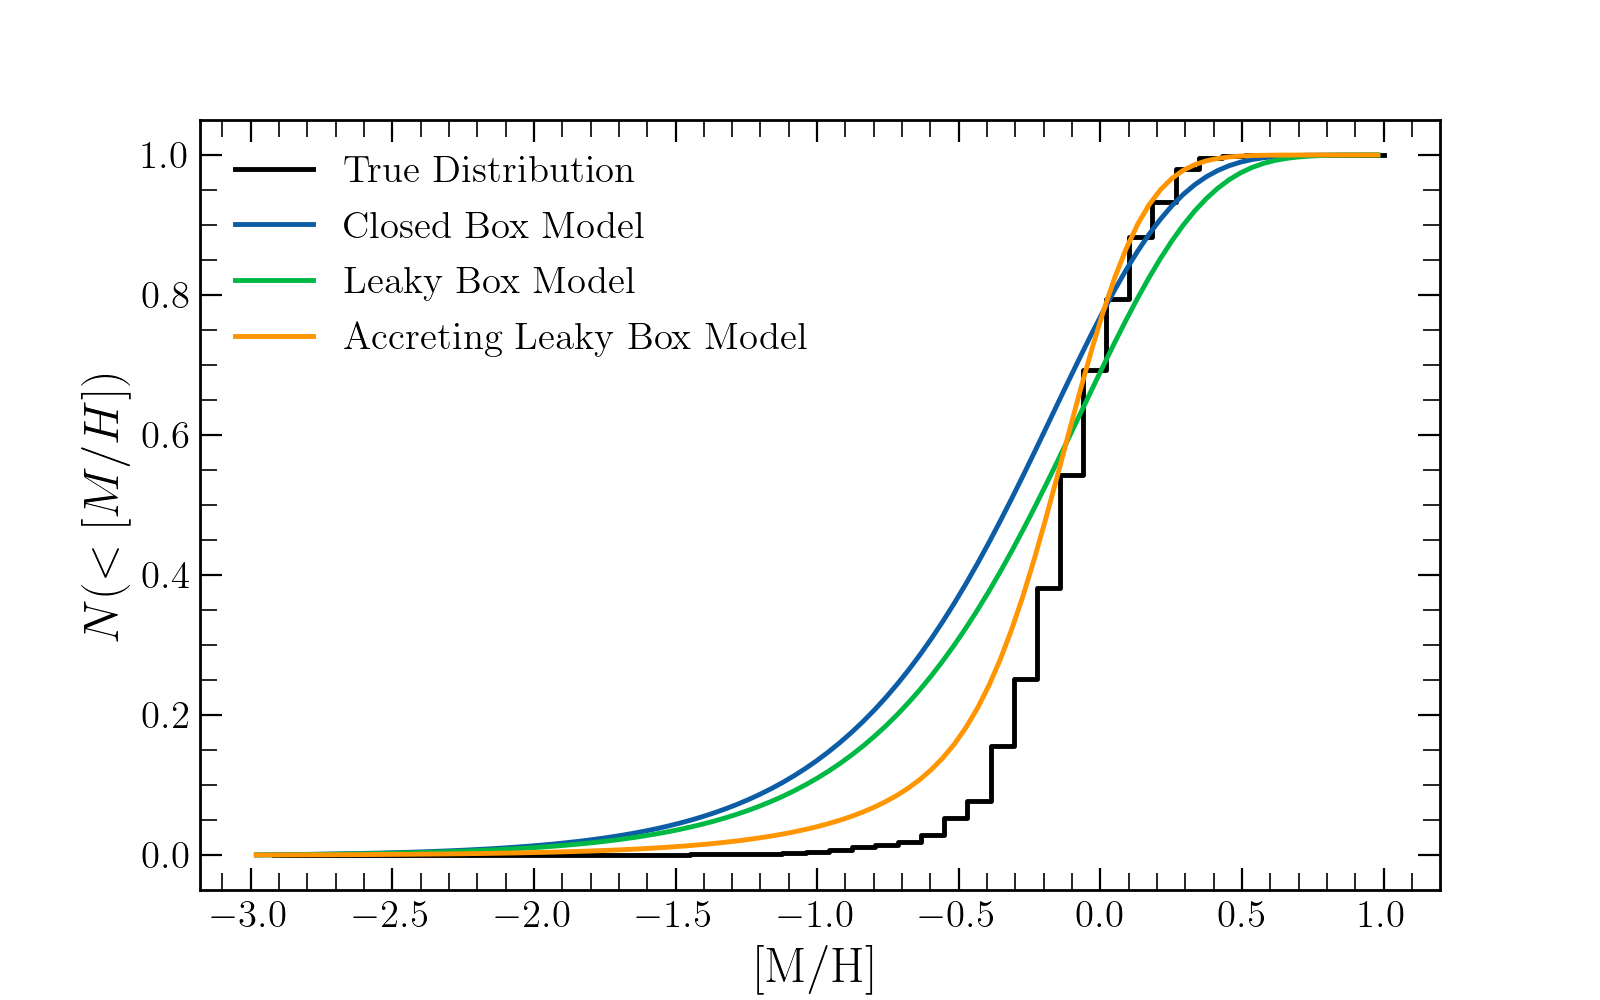

interactive(children=(FloatSlider(value=0.1, description='z_yield', max=0.2, step=0.01), FloatSlider(value=2.5…

<function __main__.update(z_yield=0.1, eta=2.5, r=0.4)>

In [9]:
fig = plt.figure(figsize=(8, 5))
ax1 = plt.subplot(111)

c, b = get_sn_xhdist("Mg", bins=np.linspace(-3, 1, 50))
line1, = ax1.step(b + np.diff(b)[0] / 2, np.cumsum(c / np.trapz(c, b)) / np.sum(c / np.trapz(c, b)), label='True Distribution', color='k')

# Fit Distribution -> Closed
c, b = get_sn_xhdist("Mg", bins=np.linspace(-3, 1, 100))
dN = metallicity_distribution(10 ** b)
line2, = ax1.plot(b, np.cumsum(dN / np.trapz(dN, b)) / np.sum(dN / np.trapz(dN, b)), label='Closed Box Model')

# Fit Distribution -> Leaky
dN = metallicity_distribution_leaky(10 ** b)
line3, = ax1.plot(b, np.cumsum(dN / np.trapz(dN, b)) / np.sum(dN / np.trapz(dN, b)), label='Leaky Box Model')

# Fit Distribution -> Leaky Accreting
dN = metallicity_distribution_accreting_leaky(10 ** b)
k = gaussian_filter1d(np.abs(dN), 5)
line4, = ax1.plot(b, k / np.trapz(k, b) / np.sum(dN / np.trapz(dN, b)), label='Accreting Leaky Box Model')

ax1.set_xlabel(r'$[\rm M/H]$')
ax1.set_ylabel(r'$N(< [M/H])$')
ax1.legend(frameon=False, fontsize=14)

def update(z_yield=0.1, eta=2.5, r=0.4):
    """
    """        
    dN = metallicity_distribution_leaky(10 ** b, z_yield=z_yield)
    line3.set_ydata(np.cumsum(dN / np.trapz(dN, b)) / np.sum(dN / np.trapz(dN, b)))
    
    dN = metallicity_distribution_accreting_leaky(10 ** b, z_yield=z_yield, eta=eta, r=r)
    k = gaussian_filter1d(np.abs(dN), 5)
    line4.set_ydata(np.cumsum(k / np.trapz(k, b)) / np.sum(k / np.trapz(dN, b)))

    fig.canvas.draw()

    
interact(update, z_yield=(0.0, 0.2, 0.01), eta=(0, 5, 0.05), r=(0, 0.9, 0.05))

<IPython.core.display.Javascript object>


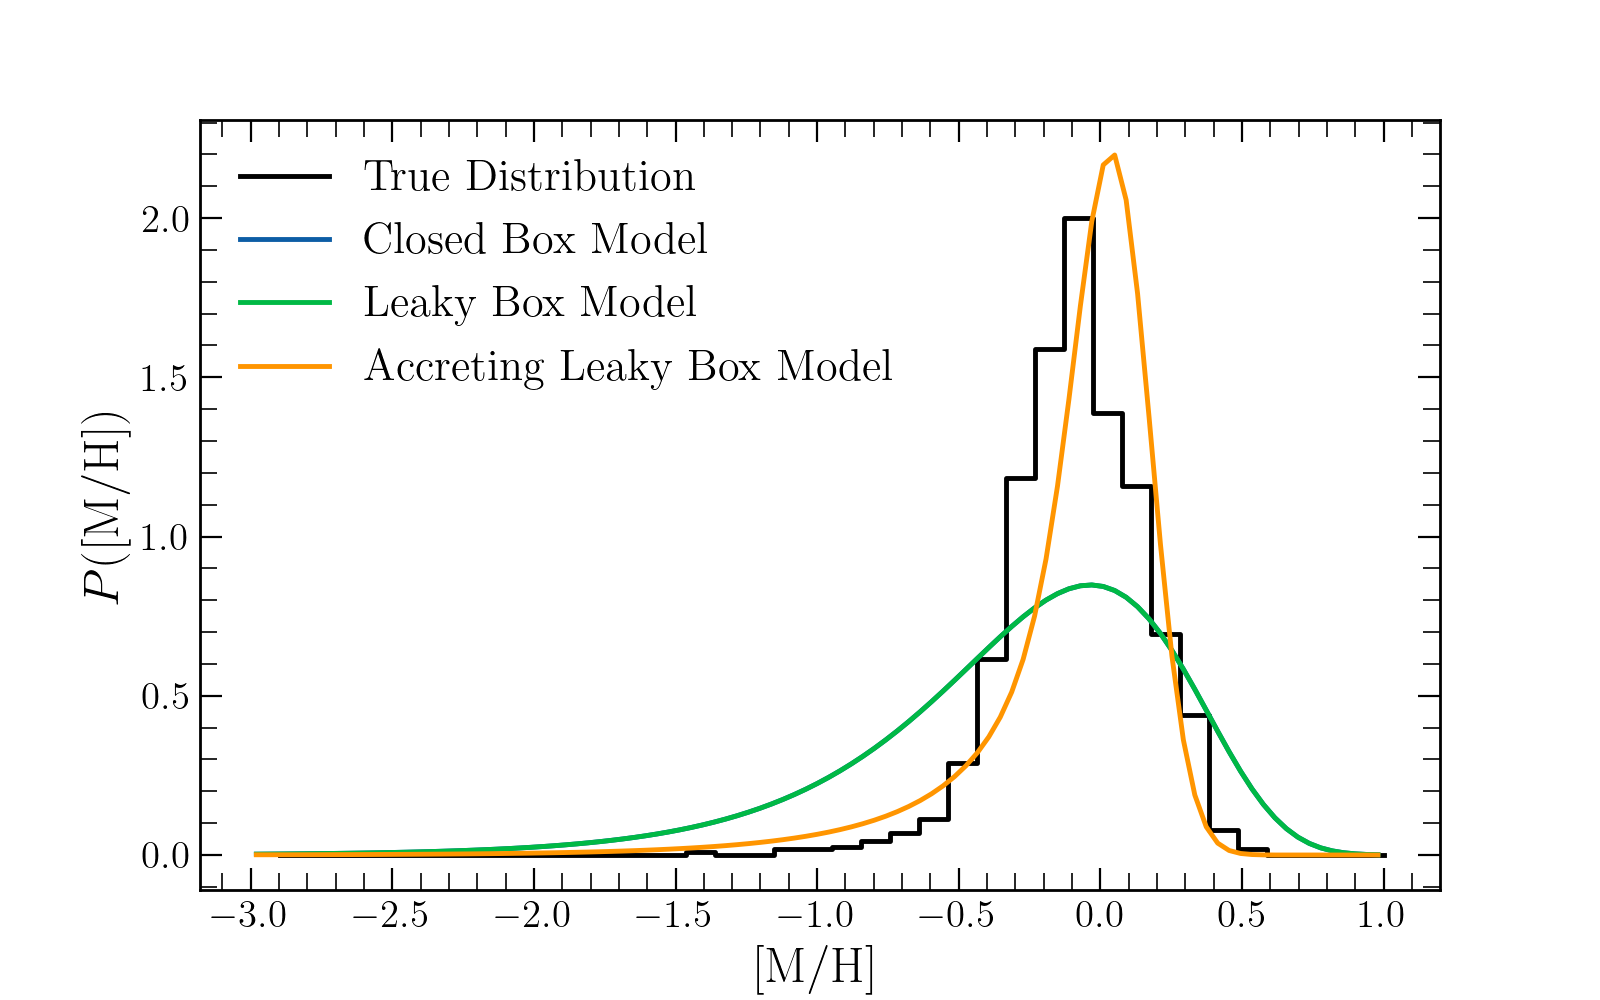

[0.10504212 4.99565616 0.45039095] [[ 2.25550822e-18 -1.28306953e-10  1.28306940e-10]
 [-1.28306953e-10  1.02306714e-02 -1.02306704e-02]
 [ 1.28306940e-10 -1.02306704e-02  1.02306693e-02]]


In [7]:
plt.figure(figsize=(8, 5))


# True Distribution
c, b = get_sn_xhdist("Mg", bins=np.linspace(-3, 1, 40))
plt.step(b + np.diff(b)[0] / 2, c / np.trapz(c, b), label='True Distribution', color='k')

# Fit Distribution -> Closed
c, b = get_sn_xhdist("Mg", bins=np.linspace(-3, 1, 100))
popt, pcov = curve_fit(fit_closed, b, c / np.trapz(c, b), bounds=((0.001), (0.4)))
dN = metallicity_distribution(10 ** b, z_yield=popt[0])
plt.plot(b, dN / np.trapz(dN, b), label='Closed Box Model')

# Fit Distribution -> Leaky
popt, pcov = curve_fit(fit_leaky, b, c / np.trapz(c, b))
dN = metallicity_distribution_leaky(10 ** b, z_yield=popt[0], eta=popt[1])
plt.plot(b, dN / np.trapz(dN, b), label='Leaky Box Model')


# Fit Distribution -> Leaky Accreting
popt, pcov = curve_fit(
    fit_accreting_leaky, b, c / np.trapz(c, b), bounds=((0.001, 0, 0), (0.2, 10, 0.9))
)
print(popt, pcov)
dN = metallicity_distribution_accreting_leaky(10 ** b, *popt)
k = gaussian_filter1d(np.abs(dN), 3)
plt.plot(b, k / np.trapz(k, b), label='Accreting Leaky Box Model')
plt.legend(frameon=False, fontsize=16)

plt.xlabel(r'$[\rm M/H]$')
plt.ylabel(r'$P([\rm M/H])$')
plt.show()